## Homework 2 - How do Taxis move in NYC?

## Python libraries

In [146]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import math
import os, json, requests, pickle
from scipy.stats import skew
from scipy.stats import ttest_ind, f_oneway, lognorm, levy, skew, chisquare,  pearsonr
import seaborn as sns
from sklearn.preprocessing import normalize, scale
import warnings
warnings.filterwarnings('ignore')

from datetime import timedelta

from scipy import stats

import matplotlib.mlab as mlab

## Data

NYC Taxi rides in 2018

Source: http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml

## Data dictionary

* vendor_id - a code indicating the provider associated with the trip record
* pickup_datetime - date and time when the meter was engaged
* dropoff_datetime - date and time when the meter was disengaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* Trip_distance - The elapsed trip distance in miles reported by the taximeter
* PULocationID - TLC Taxi Zone in which the taximeter was engaged
* DOLocationID - TLC Taxi Zone in which the taximeter was disengaged
* Payment_type - A numeric code signifying how the passenger paid for the trip
* Fare_amount - The time-and-distance fare calculated by the meter
* Total_amount - The total amount charged to passengers. Does not include cash tips

## Import data

In [2]:
# Import csv files per each month
#yellow_2018_01=pd.read_csv('C:\\Users\\Olya\\Documents\\Various documents\\Masters\\La Sapienza\\ADM\\Homework\\Homework 2\\yellow_tripdata_2018-01.csv',encoding='latin1')
#yellow_2018_02=pd.read_csv('C:\\Users\\Olya\\Documents\\Various documents\\Masters\\La Sapienza\\ADM\\Homework\\Homework 2\\yellow_tripdata_2018-02.csv',encoding='latin1')
#yellow_2018_03=pd.read_csv('C:\\Users\\Olya\\Documents\\Various documents\\Masters\\La Sapienza\\ADM\\Homework\\Homework 2\\yellow_tripdata_2018-03.csv',encoding='latin1')
yellow_2018_04=pd.read_csv('C:\\Users\\Olya\\Documents\\Various documents\\Masters\\La Sapienza\\ADM\\Homework\\Homework 2\\yellow_tripdata_2018-04.csv',encoding='latin1')
yellow_2018_05=pd.read_csv('C:\\Users\\Olya\\Documents\\Various documents\\Masters\\La Sapienza\\ADM\\Homework\\Homework 2\\yellow_tripdata_2018-05.csv',encoding='latin1')
yellow_2018_06=pd.read_csv('C:\\Users\\Olya\\Documents\\Various documents\\Masters\\La Sapienza\\ADM\\Homework\\Homework 2\\yellow_tripdata_2018-06.csv',encoding='latin1')

In [3]:
# Concatenate input files
input_data =  [yellow_2018_04,yellow_2018_05,yellow_2018_06]
yellow_2018 = pd.concat(input_data)
del input_data
del yellow_2018_04
del yellow_2018_05 
del yellow_2018_06

In [4]:
# import reference data for taxi zones
taxi_zones=pd.read_csv('C:\\Users\\Olya\\Documents\\Various documents\\Masters\\La Sapienza\\ADM\\Homework\\Homework 2\\taxi_zone_lookup.csv',encoding='latin1')

In [5]:
# Merge the data set with the reference data for taxi zones
yellow_2018_tz = yellow_2018.merge(taxi_zones,left_on='PULocationID', right_on='LocationID')
del yellow_2018

In [6]:
# columns tpep_pickup_datetime and tpep_dropoff_datetime are in string format
# to caclulate duration of the ride we need to convert them to date format which can be done using strptime function from datetime
yellow_2018_tz['tpep_dropoff_datetime'] = yellow_2018_tz['tpep_dropoff_datetime'].map(lambda tpep_dropoff_datetime: datetime.strptime(tpep_dropoff_datetime, "%Y-%m-%d %H:%M:%S"))

In [7]:
yellow_2018_tz['tpep_pickup_datetime'] = yellow_2018_tz['tpep_pickup_datetime'].map(lambda tpep_pickup_datetime: datetime.strptime(tpep_pickup_datetime, "%Y-%m-%d %H:%M:%S"))

In [8]:
# adding new column trip_duration into the data set
yellow_2018_tz['trip_duration']=(yellow_2018_tz['tpep_dropoff_datetime']-yellow_2018_tz['tpep_pickup_datetime'])/timedelta(minutes=1)

In [9]:
# to plot trip duration in more readable form values will be rounded upwards (ceiled)
yellow_2018_tz['trip_duration']=yellow_2018_tz['trip_duration'].map(lambda trip_duration: math.ceil(trip_duration))

## Data clean up

Take into account trips where:

- Trip distance is positive and greater than 0
- Trip duration is positive and greater than 0
- Number of passangers is positive and greater than 0
- Drop off time is after the pick up time
- Pick up time is in 2018
* Total amount is positive and greater than 0

In [10]:
yellow_2018_tz = yellow_2018_tz[yellow_2018_tz['trip_distance'] > 0]
yellow_2018_tz = yellow_2018_tz[yellow_2018_tz['trip_duration'] > 0]
yellow_2018_tz = yellow_2018_tz[yellow_2018_tz['passenger_count']>0]
yellow_2018_tz = yellow_2018_tz[yellow_2018_tz['tpep_pickup_datetime']<yellow_2018_tz['tpep_dropoff_datetime']]
yellow_2018_tz = yellow_2018_tz[yellow_2018_tz['tpep_pickup_datetime']>datetime(2017,12,31)]
yellow_2018_tz = yellow_2018_tz[yellow_2018_tz['total_amount']>0]

## RQ1

In what period of the year Taxis are used more? 
Create a plot that, for each month, shows the average number of trips recorded each day. 
Due to the differences among New York zones, we want to visualize the same information for each boroughs. 
Do you notice any difference among them? Provide comments and plausible explanations about what you observe 
(e.g.: what is the month with the highest daily average?).

We calculated weighted hourly average of number of trips per day in order to understand which are the peak hours.

In [15]:
dates = list(yellow_2018_tz['tpep_pickup_datetime'])

In [16]:
###########Dictionary that, for each day of the month, saves the list of all time slots and the related number of trips### 
days_hours=dict()
for el in dates:
    el=str(el)
    el=el.split(' ')
    time=el[1]
    hour=time[:2]
    date=el[0]
    day=date[-2:]
    if day not in days_hours.keys():
        days_hours[day]=[[hour, 1]]
    else:
        updated=False
        for l in days_hours[day]:
            if l[0]==hour:
            #we update the occurrence for that hour with another trip
                l[1]+=1
                updated=True
            else:
                continue
        if updated==False:
            days_hours[day].append([hour, 1])



In [20]:
d=dict()
s=0
for key in days_hours.keys():
    for lista in days_hours[key]:
        lista=lista[1]
        s += int(lista)
    d[int(key)]= s
    s=0
                        

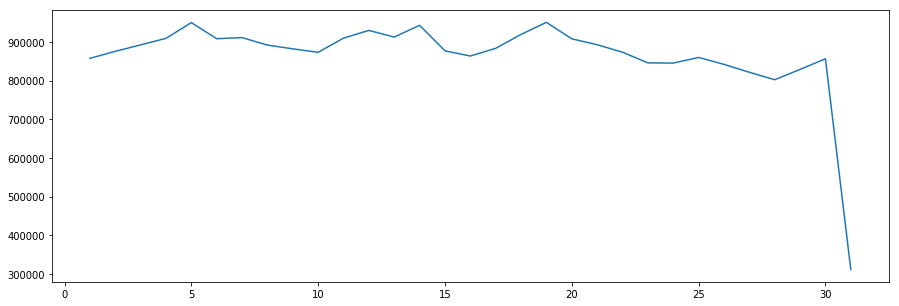

In [58]:
%matplotlib inline
fig,ax = plt.subplots(figsize = (15,5)) 
plt.plot(*zip(*sorted(d.items())))
plt.show()

In [59]:
del d

In [30]:
#now we will compute the weighted mean hour for each day, putting all in a dictionary with key = day and value = mean
means_dict=dict()
for key in days_hours.keys():
    product_sum=0
    denominator_sum=0
    day_list=days_hours[key]
    for el in day_list:
        product_sum+=int(el[0])*el[1]
        denominator_sum+=el[1]
    means_dict[key]=product_sum/denominator_sum

We decided to plot the weighted hourly average per day, for seeing the busiest hours.
Thus, we observed that the average timeslot in which people in NY took taxi, was in the lunchtime (13h-14h).

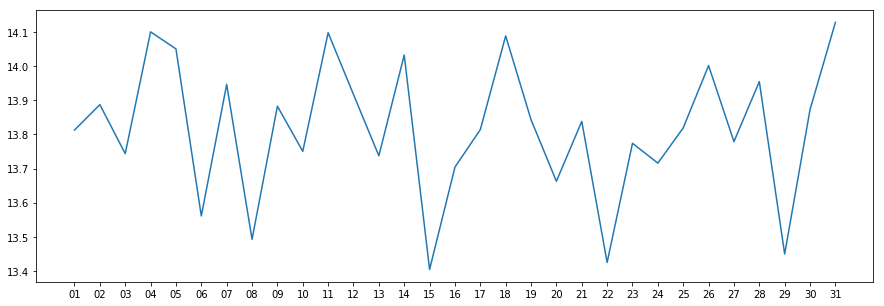

In [38]:
fig,ax = plt.subplots(figsize = (15,5)) 
plt.plot(*zip(*sorted(means_dict.items())))

plt.show()

In [60]:
del means_dict

In [55]:
del days_hours

We computed the average number of trips per day for each borough:

In [82]:
df_atd=yellow_2018_tz[['tpep_pickup_datetime','Borough']]

In [83]:
df_atd.iloc[:,0]=df_atd.iloc[:,0].apply(lambda x: pd.to_datetime(x).day)

In [84]:
df_atd = df_atd[['tpep_pickup_datetime','Borough']].groupby(['tpep_pickup_datetime','Borough'])['tpep_pickup_datetime'].size().unstack()
df_atd_1 = df_atd.mean(axis=0)

In [86]:
df_atd_1

Borough
Bronx               948.774194
Brooklyn          11474.032258
EWR                  20.193548
Manhattan        785981.612903
Queens            55651.645161
Staten Island        10.806452
Unknown           11697.774194
dtype: float64

In [87]:
del df_atd
del df_atd_1

## RQ2

What are the time slots with more passengers? 
Set your own time slots and discover which are those when Taxis drive the highest number of passengers overall New York and repeat the analysis for each borough. 
Provide the results through a visualization and comment them.

In [109]:
passenger_count=yellow_2018_tz['passenger_count']

In [96]:
dropoff_time=yellow_2018_tz.tpep_dropoff_datetime.dt.hour

In [120]:
borough = yellow_2018_tz['Borough']

In [121]:
df=pd.concat([pd.Series(dropoff_time), passenger_count,borough], axis=1)

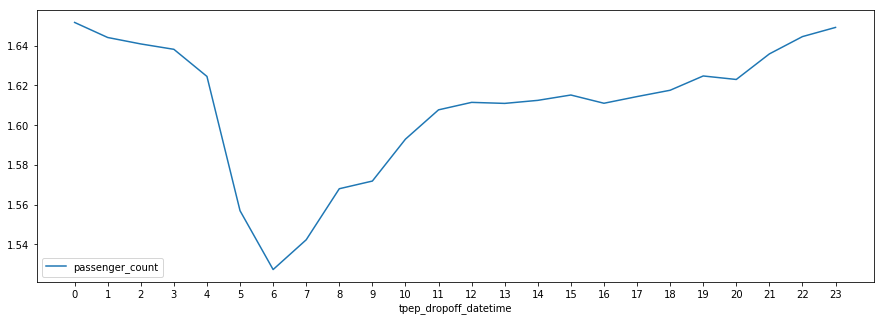

In [122]:
df.groupby('tpep_dropoff_datetime').mean().plot(kind="line", xticks=[x for x in range(0,24)],figsize=(15,5))

We combined data about number of passengers and timeslots.
From the graph we see that the least number of passangers is in the morning around 6 am and the highest number of passangers is
around midnight.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002568C2EAC88>,
      dtype=object)

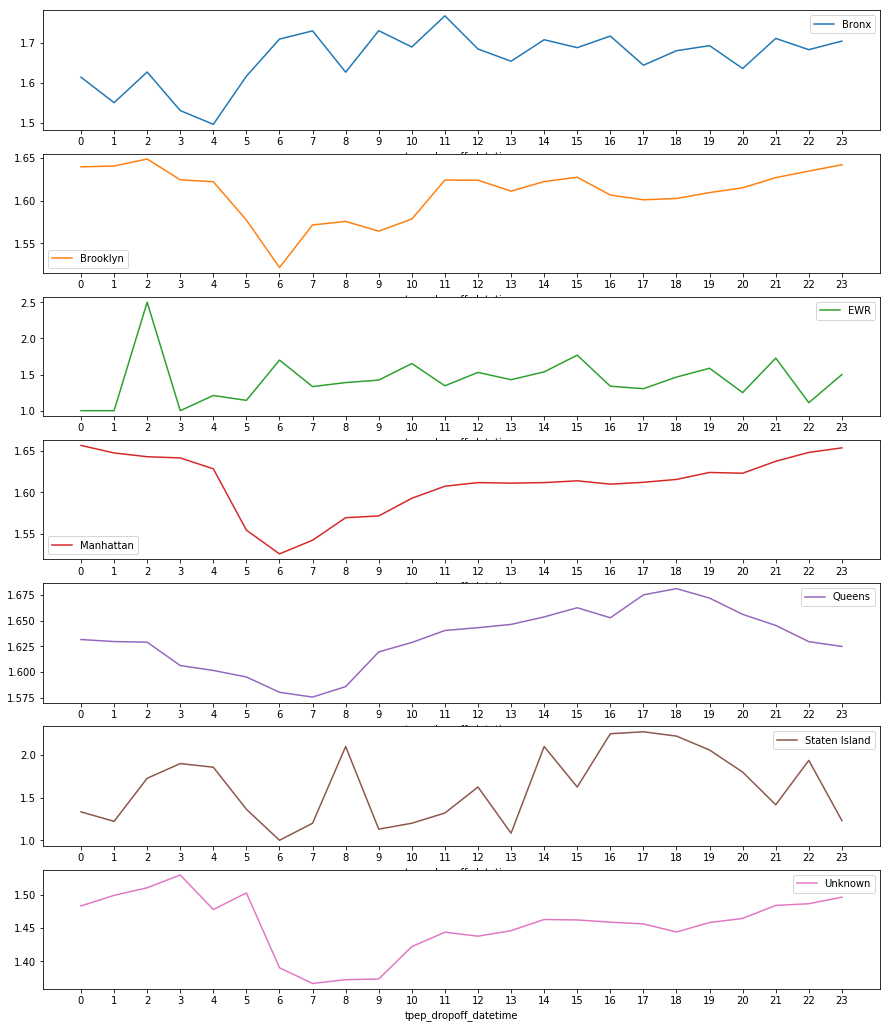

In [129]:
fig, ax = plt.subplots(7,1,figsize=(15,18))
df.groupby(['tpep_dropoff_datetime','Borough'])['passenger_count'].mean().unstack().plot(ax=ax,subplots=True,xticks=[x for x in range(0,24)])

The trends of the average number of passengers per hour in different borough are not similar.
We can say that Brooklyn and Manhattan follow the same pattern like overall NYC.
Most of the time, we saw that taking taxis early in the morning is not common.

In [130]:
del df
del borough

## RQ3

Do the all trips last the same? 
Let's put our attention on the distribution of trip's duration. 
Provide a plot for it and comment what you see. Run this analysis for NYC and for each borough (and obviously comment the results!).

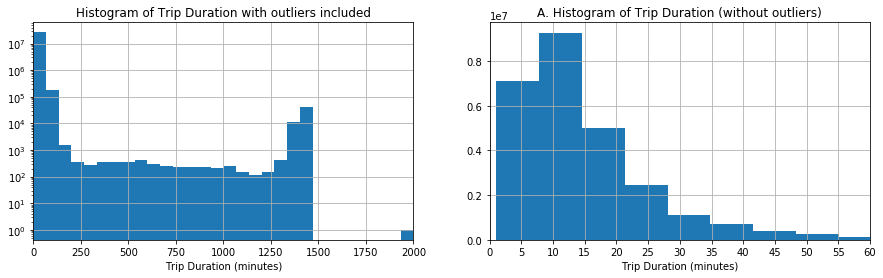

In [137]:
%matplotlib inline

# define the figure with 2 subplots
fig,ax = plt.subplots(1,2,figsize = (15,4)) 

# histogram of the number of trip distance
yellow_2018_tz.trip_duration.hist(bins=30,ax=ax[0])
ax[0].set_xlabel('Trip Duration (minutes)')
#ax[0].set_ylabel('Count')
ax[0].set_yscale('log')
ax[0].set_title('Histogram of Trip Duration with outliers included')
ax[0].set_xlim([0,2000])

# create a vector to contain Trip Duration
v = yellow_2018_tz.trip_duration
# exclude any data point located further than 3 standard deviations of the median point and 
# plot the histogram with 30 bins
v[~((v-v.median()).abs()>3*v.std())].hist (bins=30,ax=ax[1]) # 
c=0
x=[]
while c<=60:
    x.append(c)
    c+=5
ax[1].set_xticks(x) 
ax[1].set_xlabel('Trip Duration (minutes)')
#ax[1].set_ylabel('Count')
ax[1].set_title('A. Histogram of Trip Duration (without outliers)')
ax[1].set_xlim([0,60])

plt.show()

Because we noticed that there are some records with very long trip durations which are probably uncorrect, we decided to focus on
trip durations which are maximum 3 standard deviations far from the mean. 
From the corrected data we can see that the most frequent trip duration is between 8 and 14 minutes. The plot has the shape of right skewed distribution.

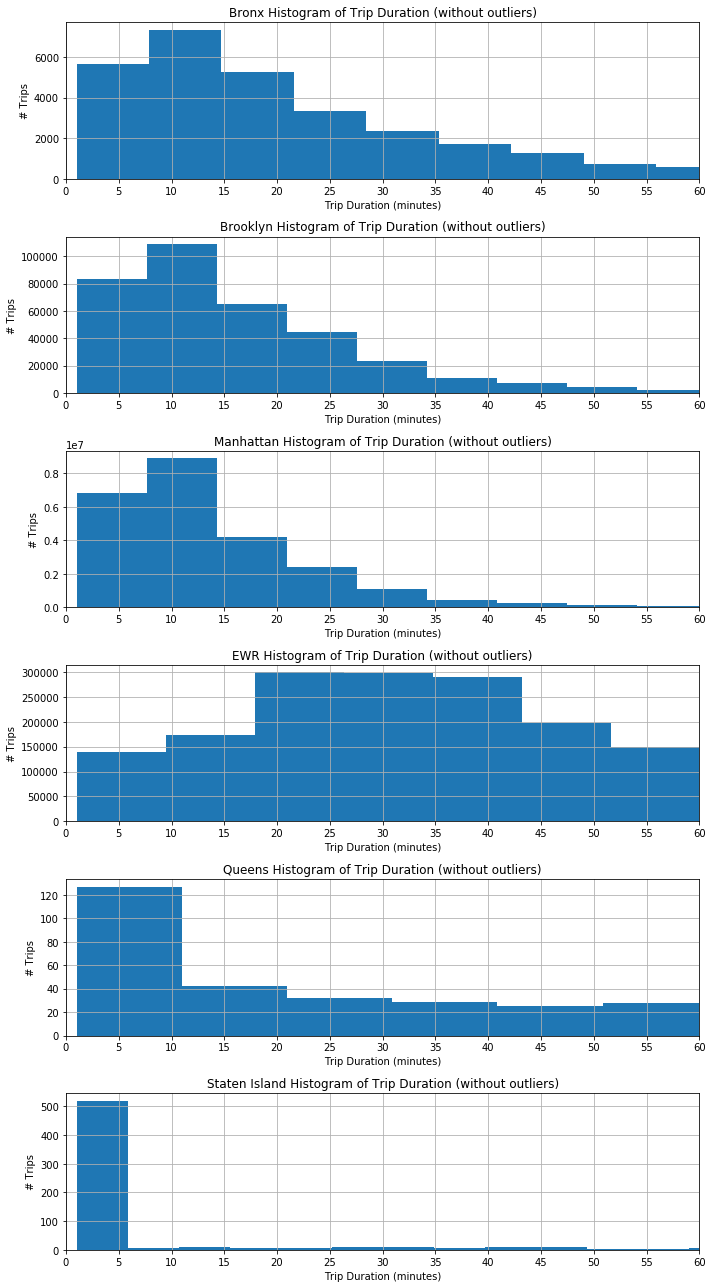

In [136]:
#boroughs=[,'Brooklyn','EWR','Manhattan','Queens','Staten Island','Unknown']
bronx_rides  = yellow_2018_tz.loc[(yellow_2018_tz['Borough']) == 'Bronx']
brooklyn_rides  = yellow_2018_tz.loc[(yellow_2018_tz['Borough'] == 'Brooklyn')]
ewr_rides  = yellow_2018_tz.loc[(yellow_2018_tz['Borough'] == 'EWR')]
manhattan_rides  = yellow_2018_tz.loc[(yellow_2018_tz['Borough'] == 'Manhattan')]
queens_rides  = yellow_2018_tz.loc[(yellow_2018_tz['Borough'] == 'Queens')]
si_rides  = yellow_2018_tz.loc[(yellow_2018_tz['Borough'] == 'Staten Island')]
#unknown_rides  = yellow_2018_06_with_tz.loc[(yellow_2018_06_with_tz['Borough'] == 'Unknown')]

# create a vector to contain Trip Duration
v_bronx = bronx_rides.trip_duration
v_brooklyn = brooklyn_rides.trip_duration
v_ewr = ewr_rides.trip_duration
v_manhattan = manhattan_rides.trip_duration
v_queens = queens_rides.trip_duration
v_si = si_rides.trip_duration

c=0
x=[]
while c<=60:
    x.append(c)
    c+=5
fig,ax = plt.subplots(6,1,figsize = (10,18)) 

# exclude any data point located further than 3 standard deviations of the median point and 
# plot the histogram with 30 bins

v_bronx[~((v_bronx-v_bronx.median()).abs()>3*v_bronx.std())].hist (bins=30,ax=ax[0]) 
v_brooklyn[~((v_brooklyn-v_brooklyn.median()).abs()>3*v_brooklyn.std())].hist (bins=30,ax=ax[1]) 
v_ewr[~((v_ewr-v_ewr.median()).abs()>3*v_ewr.std())].hist (bins=30,ax=ax[5])
v_manhattan[~((v_manhattan-v_manhattan.median()).abs()>3*v_manhattan.std())].hist (bins=30,ax=ax[2])
v_queens[~((v_queens-v_queens.median()).abs()>3*v_queens.std())].hist (bins=30,ax=ax[3])
v_si[~((v_si-v_si.median()).abs()>3*v_si.std())].hist (bins=30,ax=ax[4])

ax[0].set_xticks(x) 
ax[0].set_xlabel('Trip Duration (minutes)')
ax[0].set_ylabel('# Trips')
ax[0].set_title('Bronx Histogram of Trip Duration (without outliers)')
ax[0].set_xlim([0,60])
fig.tight_layout() 
    
ax[1].set_xticks(x) 
ax[1].set_xlabel('Trip Duration (minutes)')
ax[1].set_ylabel('# Trips')
ax[1].set_title('Brooklyn Histogram of Trip Duration (without outliers)')
ax[1].set_xlim([0,60])
fig.tight_layout() 

ax[2].set_xticks(x) 
ax[2].set_xlabel('Trip Duration (minutes)')
ax[2].set_ylabel('# Trips')
ax[2].set_title('Manhattan Histogram of Trip Duration (without outliers)')
ax[2].set_xlim([0,60])
fig.tight_layout() 

ax[3].set_xticks(x) 
ax[3].set_xlabel('Trip Duration (minutes)')
ax[3].set_ylabel('# Trips')
ax[3].set_title('EWR Histogram of Trip Duration (without outliers)')
ax[3].set_xlim([0,60])
fig.tight_layout()

ax[4].set_xticks(x) 
ax[4].set_xlabel('Trip Duration (minutes)')
ax[4].set_ylabel('# Trips')
ax[4].set_title('Queens Histogram of Trip Duration (without outliers)')
ax[4].set_xlim([0,60])
fig.tight_layout() 

ax[5].set_xticks(x) 
ax[5].set_xlabel('Trip Duration (minutes)')
ax[5].set_ylabel('# Trips')
ax[5].set_title('Staten Island Histogram of Trip Duration (without outliers)')
ax[5].set_xlim([0,60])
fig.tight_layout() 

plt.show()

Bronx, Brooklyn and Manhattan have approximately the same trip duration frequency like overall NYC. 
Histagram for EWR shows higher frequency of longer trip durations, between 18 and 43 minutes, which is expected taking into account that
it is airport area, further from the city center.

In [ ]:
del bronx_rides
del brooklyn_rides
del ewr_rides
del manhattan_rides 
del queens_rides
del si_rides 
del v_bronx
del v_brooklyn
del v_ewr
del v_manhattan 
del v_queens 
del v_si 

## RQ4

What is the most common way of payments? 
Discover the way payments are executed in each borough and visualize the number of payments for any possible means. 
Then run the Chi-squared test to see whether the method of payment is correlated to the borough. 
Then, comment the results.

In [90]:
#Creation of boroughs column (type Series)
boroughs=yellow_2018_tz['Borough']

In [91]:
#Creation of payment_type column (type Series)
payment_type=yellow_2018_tz['payment_type']

In [235]:
#payment_type = pd.Series([dict_pay_id[x] for x in payment_type])

In [92]:
# For making the payment methods more readable 
dict_pay_id = {1:'Credit Card', 2:'Cash', 3:'No charge', 4:'Dispute', 5:'Unknown', 6:'Voided trip'}

In [93]:
# Merging the two Series in one dataframe:
df= pd.concat([boroughs,payment_type], axis = 1)

In [94]:
# Making payment method more readable
df['payment_type']=df['payment_type'].apply(lambda x: dict_pay_id[x])

In [95]:
# calculate number of payments per payment type and borough
df['count']=1
df=df.groupby(['payment_type','Borough'],as_index=False).count()

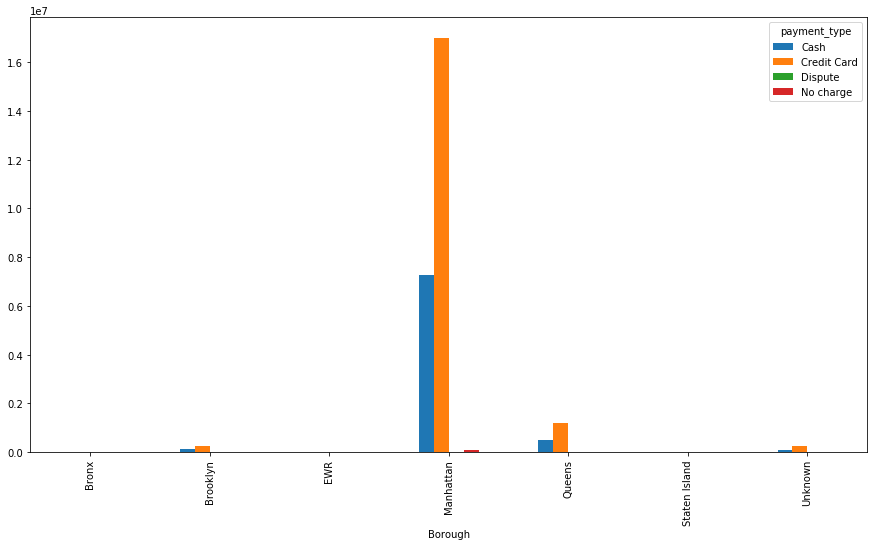

In [39]:
#fig, ax = plt.subplots(7,1,figsize=(15,18))
df.groupby(['Borough', 'payment_type'])['count'].sum().unstack().plot(kind='bar', figsize=(15,8))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000021A95EFD320>,
      dtype=object)

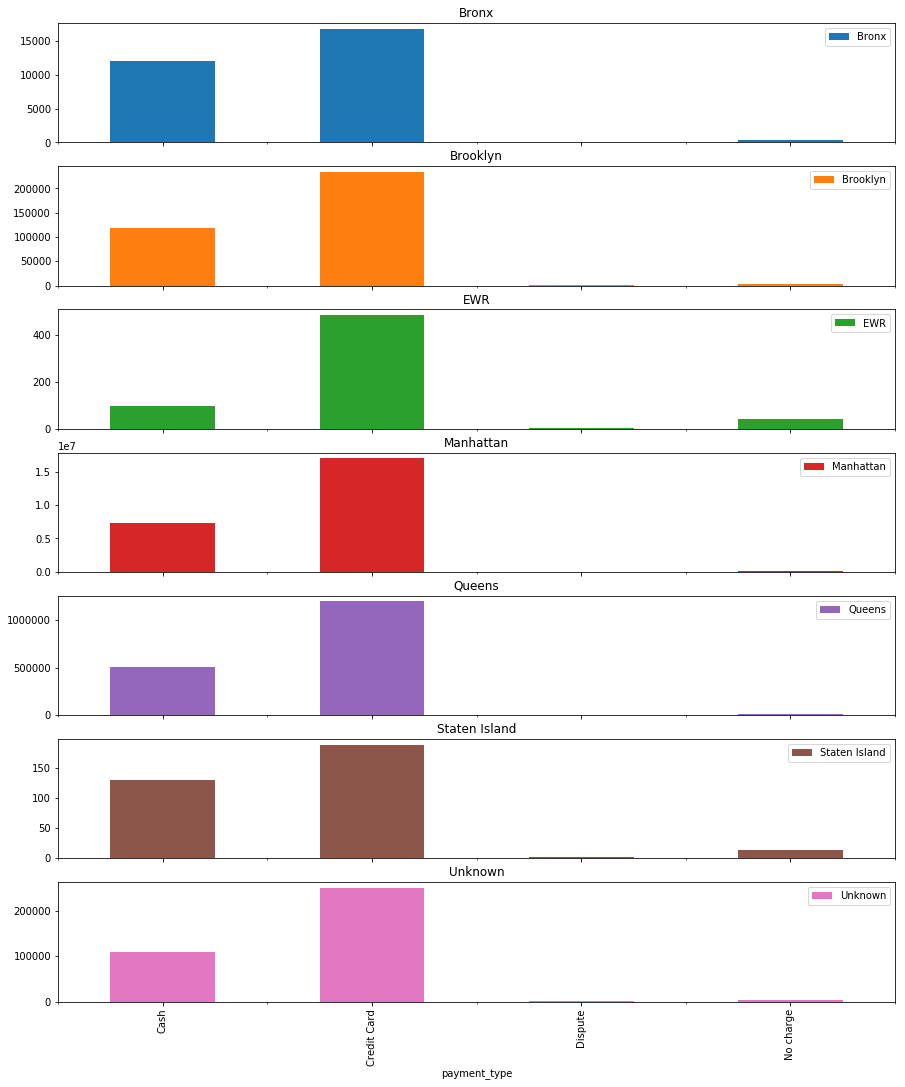

In [33]:
df.groupby(['payment_type','Borough'])['count'].sum().unstack().plot(kind='bar',subplots=True, figsize=(15,18))

Credit card is the most used way of payment, followed by Cash payments, in overall NYC and in each borough.

In [96]:
 df=df.pivot(index='Borough', columns='payment_type', values='count')

In [98]:
args=(df.iloc[0][0:4].values,df.iloc[1][0:4].values,df.iloc[2][0:4].values,df.iloc[3][0:4].values,df.iloc[4][0:4].values,df.iloc[5][0:4].values,df.iloc[6][0:4].values)

In [99]:
f_obs=np.concatenate(args)

In [101]:
# Calculate total per row
col_list= list(df)
df['row_total'] = df[col_list].sum(axis=1)

In [110]:
# Calculate total per column
#col_sums = df.select_dtypes(pd.np.number).sum().rename('col_total')
#df=df.append(col_sums)
col=['Cash','Credit Card','Dispute','No charge']
val=[]   # col total
for i in range(4):
    val.append(sum(df[col[i]]))

In [112]:
total = sum(df['row_total'])

In [113]:
# Cacluclate expected value for each cell
f_expected=[]
for j in range(7):
    for i in val:
        f_expected.append(i*df['row_total'][j]/sum(val))

In [120]:
chi_square_statistic = ((f_obs - f_expected)**2 / f_expected).sum()
print("Chi Square Statistic {}".format(chi_square_statistic))

Chi Square Statistic 16117.20771775908


In [122]:
dof = (len(df['row_total'])-1)*(len(val)-1)
print("Degree of Freedom: {}".format(dof))

Degree of Freedom: 18


In [123]:
f_obs_i = np.array(args)

In [126]:

stats.chi2_contingency(f_obs_i)

(16117.20771775908,
 0.0,
 18,
 array([[8.77300440e+03, 2.04793789e+04, 3.42224395e+01, 1.25394245e+02],
        [1.06096620e+05, 2.47668050e+05, 4.13870210e+02, 1.51645947e+03],
        [1.86723132e+02, 4.35879614e+02, 7.28384576e-01, 2.66886975e+00],
        [7.26771469e+06, 1.69654860e+07, 2.83504847e+04, 1.03878848e+05],
        [5.14592546e+05, 1.20124592e+06, 2.00736390e+03, 7.35517055e+03],
        [9.99237207e+01, 2.33258260e+02, 3.89790468e-01, 1.42822902e+00],
        [1.08165489e+05, 2.52497540e+05, 4.21940618e+02, 1.54603020e+03]]))

P Value = 0 : We can state that Null Hypothesis is rejected.
There is no correlation between the borough and the payment method.

In [127]:
del total
del f_expected
del f_obs
del f_obs_i
del chi_square_statistic
del val
del col 
del col_sums
del col_list
del dof
del df

## RQ5 
Does a long distance correlate with the duration of the trip on average? 
Make a plot that show the dependence between distance and duration of the trip. 
Then compute the Pearson Coefficient, is it significant? Comment the results you obtain.

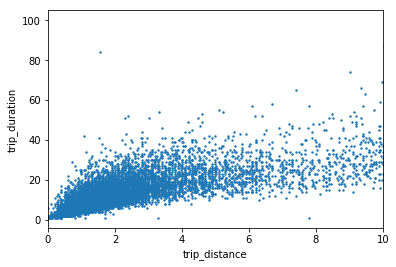

In [128]:
# Trips over 100 minutes are rare and some values are unrealisticly high. To eliminate those outliers which affect a lot
# correlation calculation, we decided to look only into trips with duration less than 100 hours
yellow_2018_tz_1 = yellow_2018_tz[yellow_2018_tz['trip_duration'] <= 100]

# For better visibility only sample of 10000 points is used 
yellow_2018_tz_s=yellow_2018_tz_1.sample(10000)
yellow_2018_tz_s.plot(x="trip_distance",y="trip_duration",kind="scatter",s=2, xlim=(0,10))

Scatter plot indicates that there could be a linear correlation between these two variables.

The Pearson correlation coefficient measures the linear relationship between two datasets. Strictly speaking, Pearson's correlation requires that each dataset be normally distributed. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact linear relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases. The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Pearson correlation at least as extreme as the one computed from these datasets.

In [129]:
pearsonr(yellow_2018_tz_1.trip_distance, yellow_2018_tz_1.trip_duration)

(0.7975616575729488, 0.0)

Pearson correlation coefficient is 0.797 and p=0.0. It means that test is statistically significant and there is a strong positive correlation between trip distance and trip duration.

In [130]:
del yellow_2018_tz_1
del yellow_2018_tz_s

## Core Research Questions

## CRQ1 

Does the fare for mile change across NY's borough? We want to discover whether the expenses of a user that enjoys Taxis in one zone is different from those that uses it in another one.

* Considering the fare amount:
Compute the price per mile equation for each trip.
Run the mean and the standard deviation of the new variable for each borough. Then plot the distribution. What do you see?
Run the t-test among all the possible pairs of distribution of different boroughs.
Can you say that statistically significant differences, on the averages, hold among zones? In other words, are Taxis trip in some boroughs, on average, more expensive than others?
* The price per mile might depend on traffic the Taxi finds on its way. So we try to mitigate this effect:
Likely, the duration of the trip says something about the city's congestion, especially if combined with the distances. It might be a good idea to weight the price for mile using the time equation needed to complete the trip. Thus, instead of equation, you can use equation, where equation is the time needed to complete the trip.
Run the mean and the standard deviation of the new variable for each borough. Then plot the distribution. What do you see?
Run the t-test among all the possible pairs of new distribution of different boroughs.
Can you say that statistically significant differences, on the averages, hold among zones? In other words, are Taxis trip in some boroughs, on average, more expensive than others?
* Compare the results obtained for the price per mile and the weighted price for mile. What do you think about that?

In [131]:
borough_list=['Bronx','Brooklyn', 'EWR', 'Manhattan', 'Queens', 'Staten Island', 'Unknown']

In [133]:
fare_per_mile = yellow_2018_tz[['total_amount', 'trip_distance']]

In [134]:
pul_column = pd.Series(yellow_2018_tz['Borough'])
fare_per_mile.loc[:,'pick_up_zone'] = pul_column

In [137]:
fare_per_mile.loc[:,'trip_duration'] = yellow_2018_tz["trip_duration"]

In [138]:
# Cleaning data
fare_per_mile = fare_per_mile[fare_per_mile['trip_distance']!=0]
fare_per_mile = fare_per_mile[fare_per_mile['total_amount'] > 0]
fare_per_mile = fare_per_mile[fare_per_mile['trip_duration'] > 0]

In [139]:
# Price per mile for each trip
price_per_mile = fare_per_mile['total_amount']/fare_per_mile['trip_distance']
fare_per_mile.loc[:,'price_per_mile'] = price_per_mile

Creating the last column about the price, but weighted using time

In [140]:
weighted_price = fare_per_mile['total_amount']/fare_per_mile['trip_duration']
fare_per_mile.loc[:,'weighted_price'] = weighted_price

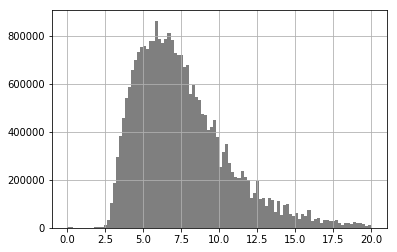

In [141]:
df_plot = fare_per_mile.loc[fare_per_mile["price_per_mile"]<20]
df_plot['price_per_mile'].hist(color='k', alpha=0.5, bins=100)

In [142]:
# Calculating the general standard deviation and mean
fare_per_mile['price_per_mile'].std()

74.54336225150925

In [143]:
fare_per_mile['price_per_mile'].mean()

9.161272524197493

In [144]:
# Developing the same (mean and standard deviation) but by borough
result_mu = fare_per_mile.groupby(['pick_up_zone'])['price_per_mile'].mean()
result_std = fare_per_mile.groupby(['pick_up_zone'])['price_per_mile'].std()

We assumed that the price per mile is normally distributed in each borough, thus for calculated mean and standard deviation we created normal
distribution plots per each borrow.

Bronx


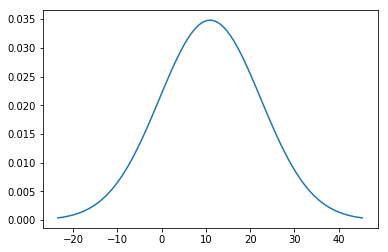

Brooklyn


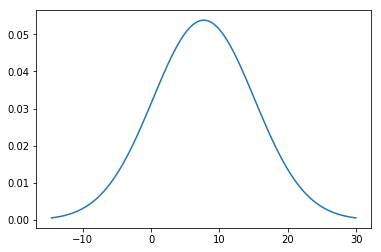

EWR


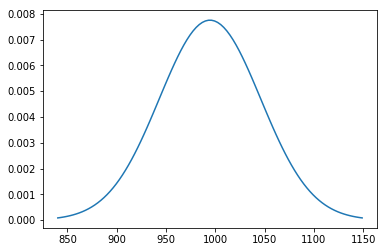

Manhattan


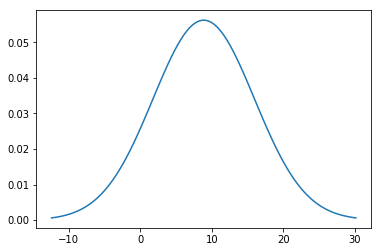

Queens


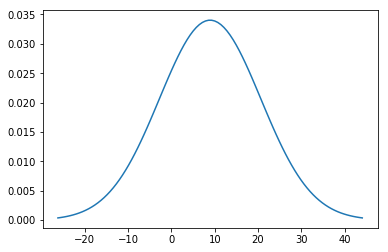

Staten Island


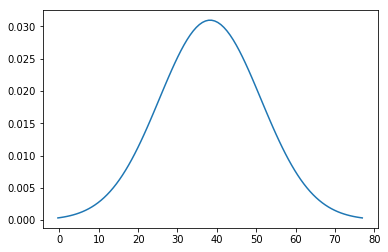

Unknown


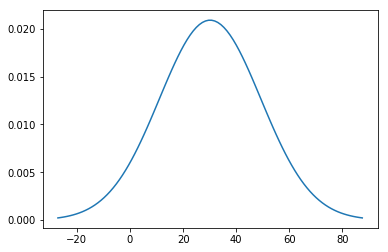

In [147]:
l=len(result_mu)
for i in range(l):
    mu = result_mu[i]
    variance = result_std[i]
    sigma = math.sqrt(variance)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    print(borough_list[i])
    plt.plot(x,mlab.normpdf(x, mu, sigma))
    plt.show()

H0 : the Taxi trip fare for the two considered boroughs are similar.

When t-test returns pvalue less than statistic value, it means that the variances are different. So our hypotesis H0 is rejected. The Taxis trip fares are different between boroughs.

In [148]:
n1_1=0
n1_2=0
for i in range(0,6):
    for j in range(i+1,6):
        
        statistic, pvalue =  ttest_ind(fare_per_mile[fare_per_mile.pick_up_zone==borough_list[i]]['price_per_mile'][:100], fare_per_mile[fare_per_mile.pick_up_zone==borough_list[j]]['price_per_mile'][:100])
        print(statistic, pvalue)
        if pvalue < statistic :
            n1_1+=1
            print(' pv < sv',borough_list[i], 'and',borough_list[j])
        else:
            n1_2+=1
            print(' pv > sv',borough_list[i], 'and', borough_list[j])
    print('\n')

0.45715402721456977 0.6480615153073777
 pv > sv Bronx and Brooklyn
-3.141590137389765 0.0019380595636790112
 pv > sv Bronx and EWR
-0.4071263726757165 0.6843549610330006
 pv > sv Bronx and Manhattan
0.3311167885165189 0.7409064331216707
 pv > sv Bronx and Queens
-1.7870161716680044 0.07546462318991236
 pv > sv Bronx and Staten Island


-3.144341392464674 0.0019207967014624751
 pv > sv Brooklyn and EWR
-0.9407520957817368 0.34797822072238094
 pv > sv Brooklyn and Manhattan
-0.23700306987563793 0.8128994380291685
 pv > sv Brooklyn and Queens
-1.8532484737187032 0.0653346512463009
 pv > sv Brooklyn and Staten Island


3.138042191742566 0.0019605331968170457
 pv < sv EWR and Manhattan
3.143694102394519 0.0019248453028938453
 pv < sv EWR and Queens
3.0491741772249603 0.0026084114531224802
 pv < sv EWR and Staten Island


0.8097435075136145 0.4190596662584384
 pv < sv Manhattan and Queens
-1.7127447659268848 0.08832491894580707
 pv > sv Manhattan and Staten Island


-1.8388211467405855 0.067

Another new column with P' = P / T, where P is price per mile and T is the time duration (for each trip)

In [149]:
result_mu_2 = fare_per_mile.groupby(['pick_up_zone'])['weighted_price'].mean()
result_std_2 = fare_per_mile.groupby(['pick_up_zone'])['weighted_price'].std()

Bronx


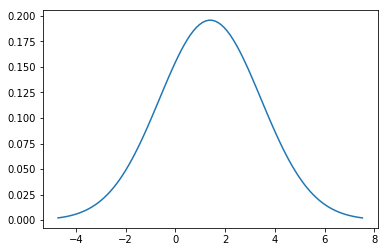

Brooklyn


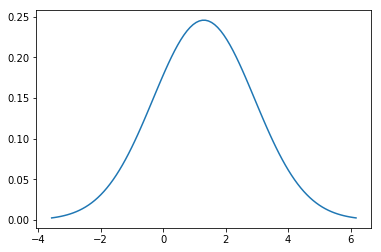

EWR


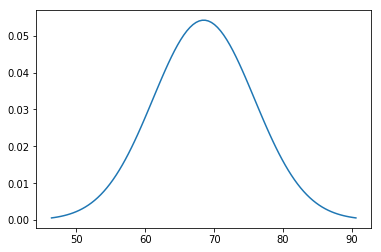

Manhattan


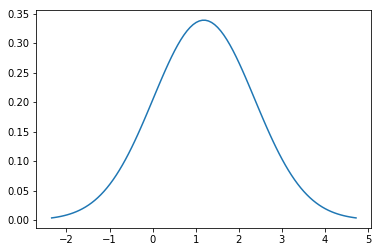

Queens


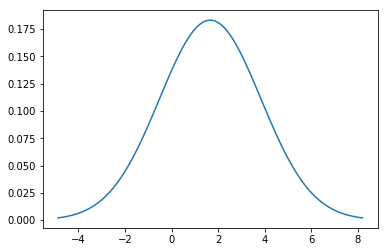

Staten Island


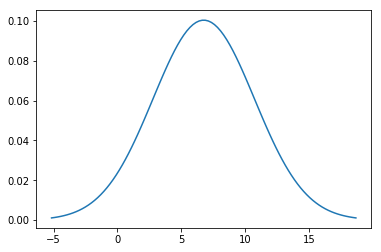

In [150]:
l=len(result_mu_2)
for i in range(l-1):  #not plotted for the last that is unknown 
    mu = result_mu_2[i]
    variance = result_std_2[i]
    sigma = math.sqrt(variance)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    print(borough_list[i])
    plt.plot(x,mlab.normpdf(x, mu, sigma))
    plt.show()

In [152]:
n2_1, n2_2 = 0,0
for i in range(0,6):   #cut unknown using this range
    for j in range(i+1,6):  
        
        statistic, pvalue =  ttest_ind(fare_per_mile[fare_per_mile.pick_up_zone==borough_list[i]]['weighted_price'][:100], fare_per_mile[fare_per_mile.pick_up_zone==borough_list[j]]['weighted_price'][:100])
        print(statistic, pvalue)
        if pvalue < statistic :
            n2_1+=1
            print('pv < sv',borough_list[i], 'and',borough_list[j])
        else:
            n2_2+=1
            print('pv > sv')
            print(borough_list[i], 'and', borough_list[j])
    print('\n')

0.4948079489950692 0.6212842965905284
pv > sv
Bronx and Brooklyn
-12.962467056965265 3.175625812848883e-28
pv > sv
Bronx and EWR
-1.0188084013741059 0.3095371823512662
pv > sv
Bronx and Manhattan
-1.7390661274196133 0.08357734065639473
pv > sv
Bronx and Queens
-3.7288455720252145 0.0002510747676378775
pv > sv
Bronx and Staten Island


-12.970601135028726 2.9985687723499947e-28
pv > sv
Brooklyn and EWR
-1.096264947514503 0.2742944101897129
pv > sv
Brooklyn and Manhattan
-2.010086382588338 0.04577911346396217
pv > sv
Brooklyn and Queens
-3.7644261404018904 0.00021995479655231897
pv > sv
Brooklyn and Staten Island


12.791018763189287 1.0634485822460433e-27
pv < sv EWR and Manhattan
12.889178340190186 5.324360288746597e-28
pv < sv EWR and Queens
11.777919813743315 1.2968409413242322e-24
pv < sv EWR and Staten Island


0.36110149103053746 0.7184085721257703
pv > sv
Manhattan and Queens
-3.0039448079442463 0.0030091201837827274
pv > sv
Manhattan and Staten Island


-3.410800921616408 0.0007

In [153]:
print('First test: price per mile')
print('number of different variances between borough:',n1_1)
print('number of same variances between borough:',n1_1)
print('Second test: weighted price')
print('number of different variances between borough:',n2_1)
print('number of same variances between borough:',n2_2)

First test: price per mile
number of different variances between borough: 4
number of same variances between borough: 4
Second test: weighted price
number of different variances between borough: 3
number of same variances between borough: 12


We showed frequencies for price per mile ttest and weighed price per mile. 

The price per mile ttests have the same number for what concerns variances similarities and differences.

For the weighted (by time) prices, it's more common to have an higher number of couples of boroughs with the same variance.


In [154]:
del result_mu
del result_std
del fare_per_mile
del price_per_mile
del weighted_price
del df_plot
del pul_column
del borough_list
del n1_1
del n1_2
del n2_1
del n2_2
del i
del j
del statistic
del pvalue